In [ ]:
# import libraries


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
# import cv2


# Load data

In [ ]:
image_size = (128,128)

base_dir = '../Face Mask Dataset/'


train_gen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)

val_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(base_dir+'Train',target_size=image_size,seed=42)
val_ds = val_gen.flow_from_directory(base_dir+'Validation',target_size=image_size,seed=42)
test_ds = test_gen.flow_from_directory(base_dir+'Test',target_size=image_size,seed=42)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../Face Mask Dataset/Train'

* Show some images

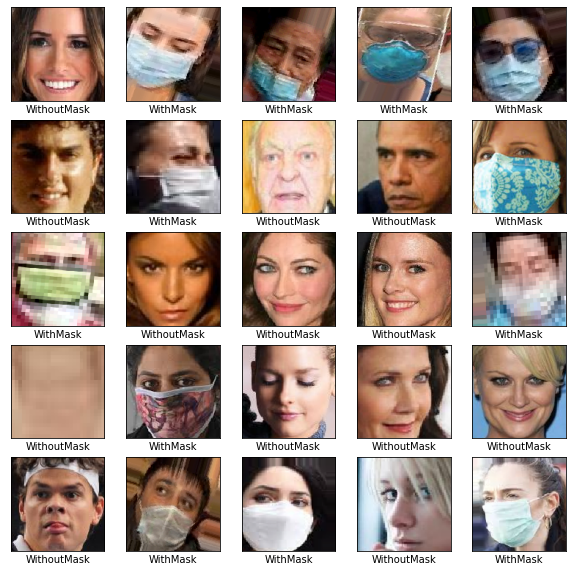

In [ ]:
class_names = {v:k for k,v in train_ds.class_indices.items()}
images,labels = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

# Build model

In [ ]:
# we use VGG19 model for mask detection

base_model = keras.applications.VGG19(include_top=False,input_shape=image_size+(3,))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(2,activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# View network architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Using EarlyStopping, end training when val_accuracy is not improved for 4 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',
                                patience=4,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 2 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',factor=0.5,
                                patience=2,verbose=1)

# training
history = model.fit(train_ds,batch_size=32,epochs=30,
        validation_data=val_ds,callbacks=[early_stopping,lr_scheduler])

Epoch 1/30
313/313 [==============================] - 71s 216ms/step - loss: 0.1765 - binary_accuracy: 0.9304 - val_loss: 0.0355 - val_binary_accuracy: 0.9931
Epoch 2/30
313/313 [==============================] - 24s 76ms/step - loss: 0.0373 - binary_accuracy: 0.9886 - val_loss: 0.0245 - val_binary_accuracy: 0.9931
Epoch 3/30
313/313 [==============================] - 24s 77ms/step - loss: 0.0271 - binary_accuracy: 0.9915 - val_loss: 0.0185 - val_binary_accuracy: 0.9962
Epoch 4/30
313/313 [==============================] - 24s 77ms/step - loss: 0.0203 - binary_accuracy: 0.9939 - val_loss: 0.0161 - val_binary_accuracy: 0.9944
Epoch 5/30
313/313 [==============================] - 24s 77ms/step - loss: 0.0149 - binary_accuracy: 0.9956 - val_loss: 0.0137 - val_binary_accuracy: 0.9950

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
313/313 [==============================] - 24s 76ms/step - loss: 0.0125 - binary_accuracy: 0.9978 - val_loss: 0.0095 

* Draw the learning curve

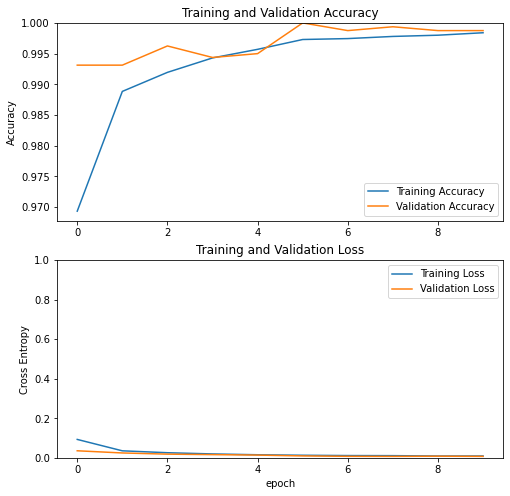

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# test model
model.evaluate(test_ds)

31/31 [==============================] - 7s 217ms/step - loss: 0.0211 - binary_accuracy: 0.9940


[0.021076757460832596, 0.9939516186714172]

* Fine tuning  


In [ ]:
# unfreeze all the layers
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.00001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [ ]:
# Using EarlyStopping, end training when val_accuracy is not improved for 4 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',
                                patience=4,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 2 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',factor=0.5,
                                patience=2,verbose=1)

# training
history = model.fit(train_ds,batch_size=32,epochs=30,
        validation_data=val_ds,callbacks=[early_stopping,lr_scheduler])

Epoch 1/30
313/313 [==============================] - 32s 99ms/step - loss: 0.0140 - binary_accuracy: 0.9950 - val_loss: 0.0020 - val_binary_accuracy: 0.9987
Epoch 2/30
313/313 [==============================] - 30s 95ms/step - loss: 0.0031 - binary_accuracy: 0.9988 - val_loss: 0.0355 - val_binary_accuracy: 0.9856
Epoch 3/30
313/313 [==============================] - 30s 97ms/step - loss: 0.0102 - binary_accuracy: 0.9959 - val_loss: 5.6461e-05 - val_binary_accuracy: 1.0000
Epoch 4/30
313/313 [==============================] - 30s 96ms/step - loss: 1.6900e-04 - binary_accuracy: 1.0000 - val_loss: 3.9961e-05 - val_binary_accuracy: 1.0000
Epoch 5/30
313/313 [==============================] - 31s 97ms/step - loss: 8.4798e-05 - binary_accuracy: 1.0000 - val_loss: 0.0195 - val_binary_accuracy: 0.9950

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 6/30
313/313 [==============================] - 31s 98ms/step - loss: 0.0011 - binary_accuracy: 0.9993 - va

In [ ]:
# test model 
model.evaluate(test_ds)

# Our model achieved 99.89% accuracy on test data.

31/31 [==============================] - 2s 68ms/step - loss: 0.0055 - binary_accuracy: 0.9990


[0.005491790361702442, 0.9989919066429138]

In [ ]:
# save model
model.save('VGG19-Face Mask Detection.h5')

# Predict

## Using haar cascade to detect faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [ ]:
# loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)} # rectangle color

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not. Those who do not wear masks are marked in red and those who do are marked in green

In [ ]:
def plot_image(image,subplot):
    plt.subplot(*subplot)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show

def predict_image(image_dir):
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    
    #returns a list of (x,y,w,h) tuples
    faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
    
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    plt.figure(figsize=(20,20))
    plot_image(out_img,(1,2,1))
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop).argmax()
        cv2.rectangle(out_img,(x,y),(x+w,y+h),dist_label[mask_result],1)
    
    plot_image(out_img,(1,2,2))

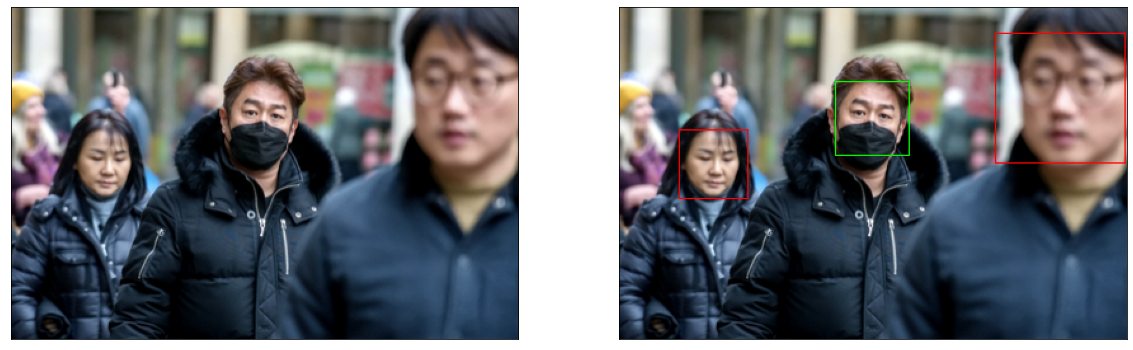

In [ ]:
predict_image('../input/face-mask-detection/images/maksssksksss244.png')

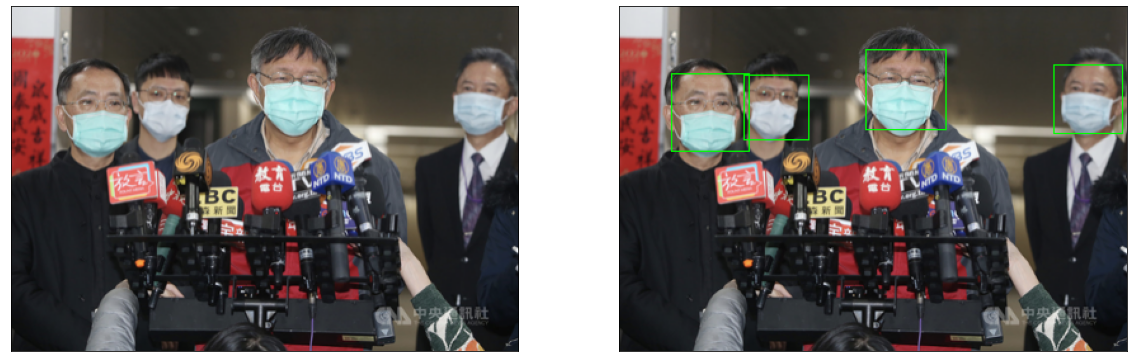

In [ ]:
predict_image('../input/face-mask-detection/images/maksssksksss174.png')

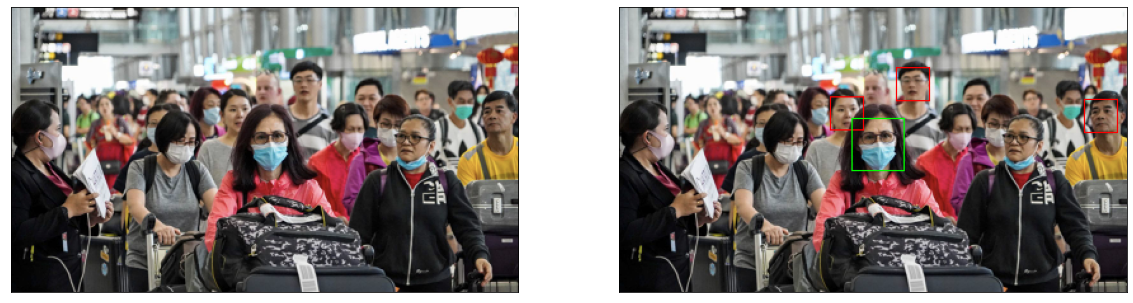

In [ ]:
predict_image('../input/face-mask-detection/images/maksssksksss388.png')